In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim

import torch.nn as nn

import numpy as np

import pickle

from torch.distributions.half_cauchy import HalfCauchy
from torch.distributions.normal import Normal

In [2]:
class BinaryMultimodalDataset(Dataset):
    
    def __init__(self, text, audio, vision, labels):
        
        self.text = text
        self.audio = audio
        self.vision = vision
        self.labels = (labels > 0).type(torch.float32)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        return self.text[idx], self.audio[idx], self.vision[idx], self.labels[idx]

In [3]:
def get_cmu_mosi_dataset(path='../../dataset/cmu-mosi/mosi_50_seq_data.pkl'):
    
    file = open(path, 'rb')
    data = pickle.load(file)
    file.close()
    
    text = torch.tensor(data['train']['text'], dtype=torch.float32)
    audio = torch.tensor(data['train']['audio'], dtype=torch.float32)
    vision = torch.tensor(data['train']['vision'], dtype=torch.float32)
    labels = torch.tensor(data['train']['labels'], dtype=torch.float32).squeeze(1)
    train_set = BinaryMultimodalDataset(text, audio, vision, labels)

    text = torch.tensor(data['valid']['text'], dtype=torch.float32)
    audio = torch.tensor(data['valid']['audio'], dtype=torch.float32)
    vision = torch.tensor(data['valid']['vision'], dtype=torch.float32)
    labels = torch.tensor(data['valid']['labels'], dtype=torch.float32).squeeze(1)
    valid_set = BinaryMultimodalDataset(text, audio, vision, labels)
    
    text = torch.tensor(data['test']['text'], dtype=torch.float32)
    audio = torch.tensor(data['test']['audio'], dtype=torch.float32)
    vision = torch.tensor(data['test']['vision'], dtype=torch.float32)
    labels = torch.tensor(data['test']['labels'], dtype=torch.float32).squeeze(1)
    test_set = BinaryMultimodalDataset(text, audio, vision, labels)
    
    return train_set, valid_set, test_set

In [4]:
class SubNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, dropout, output_size):
        
        super(SubNet, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        _, final_states = self.lstm(x)
        h = self.dropout(final_states[0]).squeeze()
        y = self.linear(h)
        return y

In [5]:
class SubNets(nn.Module):

    def __init__(self, input_size, hidden_size, dropout):
        
        super(SubNets, self).__init__()
        
        self.t_subnet = SubNet(input_size[0], hidden_size[0], dropout[0], hidden_size[0])
        self.a_subnet = SubNet(input_size[1], hidden_size[1], dropout[1], hidden_size[1])
        self.v_subnet = SubNet(input_size[2], hidden_size[2], dropout[2], hidden_size[2])
        
    def forward(self, x_t, x_a, x_v):
        
        return self.t_subnet(x_t), self.a_subnet(x_a), self.v_subnet(x_v)

In [6]:
class FusionLayer(nn.Module):
    
    def __init__(self, input_size, dropout, output_size, rank):
        
        super(FusionLayer, self).__init__()
        
        self.t_linear = nn.Linear(input_size[0], rank, bias=False)
        self.a_linear = nn.Linear(input_size[1], rank, bias=False)
        self.v_linear = nn.Linear(input_size[2], rank, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.o_linear = nn.Linear(rank, output_size, bias=False)
        
    def forward(self, x_t, x_a, x_v):
        
        y_t = self.t_linear(x_t)
        y_a = self.a_linear(x_a)
        y_v = self.v_linear(x_v)
        
        y = self.o_linear(self.dropout(y_t * y_a * y_v))
        
        return y

In [7]:
class AdaptiveFusionLayer(nn.Module):
    
    def __init__(self, input_size, dropout, output_size, max_rank, eta=0.01):
        
        super(AdaptiveFusionLayer, self).__init__()
        
        self.t_linear = nn.Linear(input_size[0], max_rank, bias=False)
        self.a_linear = nn.Linear(input_size[1], max_rank, bias=False)
        self.v_linear = nn.Linear(input_size[2], max_rank, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.o_linear = nn.Linear(max_rank, output_size, bias=False)
        
        self.max_rank = max_rank
        self.rank_param = nn.Parameter(torch.ones((max_rank,)))
        self.rank_param_dist = HalfCauchy(eta)
        
    def forward(self, x_t, x_a, x_v):
        
        y_t = self.t_linear(x_t)
        y_a = self.a_linear(x_a)
        y_v = self.v_linear(x_v)
        
        y = self.o_linear(self.dropout(y_t * y_a * y_v))
        
        return y
    
    def get_log_prior(self):
        
        rp_log_prior = torch.sum(self.rank_param_dist.log_prob(self.rank_param))
        
        t_factor_dist = Normal(0, self.rank_param)
        tf_log_prior = torch.sum(t_factor_dist.log_prob(self.t_linear.weight.T))
        af_log_prior = torch.sum(t_factor_dist.log_prob(self.a_linear.weight.T))
        vf_log_prior = torch.sum(t_factor_dist.log_prob(self.v_linear.weight.T))
        of_log_prior = torch.sum(t_factor_dist.log_prob(self.o_linear.weight))
        
        return rp_log_prior, tf_log_prior, af_log_prior, vf_log_prior, of_log_prior

In [8]:
layer = AdaptiveFusionLayer((300, 2, 2), 0, 1, 2)

In [9]:
a, b, c, d, e = layer.get_log_prior()

In [10]:
a

tensor(-10.1137, grad_fn=<SumBackward0>)

In [11]:
b

tensor(-551.6877, grad_fn=<SumBackward0>)

In [12]:
c

tensor(-3.7835, grad_fn=<SumBackward0>)

In [13]:
d

tensor(-4.1447, grad_fn=<SumBackward0>)

In [14]:
e

tensor(-2.0654, grad_fn=<SumBackward0>)

In [15]:
class FusionNetwork(nn.Module):
    
    def __init__(self, s_input_size, s_hidden_size, s_dropout,
                 f_input_size, f_dropout, f_output_size, f_rank):
        
        super(FusionNetwork, self).__init__()
        
        self.subnets = SubNets(s_input_size, s_hidden_size, s_dropout)
        self.fusion_layer = FusionLayer(f_input_size, f_dropout, f_output_size, f_rank)
        
    def forward(self, x_t, x_a, x_v):
            
        y_t, y_a, y_v = self.subnets(x_t, x_a, x_v)
        
        batch_size = y_t.shape[0]
        
        y_t = torch.cat((y_t, torch.ones((batch_size, 1))), dim=1)
        y_a = torch.cat((y_a, torch.ones((batch_size, 1))), dim=1)
        y_v = torch.cat((y_v, torch.ones((batch_size, 1))), dim=1)

        y = self.fusion_layer(y_t, y_a, y_v)
        
        return y

In [16]:
class AdaptiveFusionNetwork(nn.Module):
    
        
    def __init__(self, s_input_size, s_hidden_size, s_dropout,
                 f_input_size, f_dropout, f_output_size, f_max_rank):
        
        super(AdaptiveFusionNetwork, self).__init__()
        
        self.subnets = SubNets(s_input_size, s_hidden_size, s_dropout)
        self.fusion_layer = AdaptiveFusionLayer(f_input_size, f_dropout, f_output_size, f_max_rank)
        
    def forward(self, x_t, x_a, x_v):
            
        y_t, y_a, y_v = self.subnets(x_t, x_a, x_v)
        
        batch_size = y_t.shape[0]
        
        y_t = torch.cat((y_t, torch.ones((batch_size, 1))), dim=1)
        y_a = torch.cat((y_a, torch.ones((batch_size, 1))), dim=1)
        y_v = torch.cat((y_v, torch.ones((batch_size, 1))), dim=1)

        y = self.fusion_layer(y_t, y_a, y_v)
        
        return y

In [17]:
model = AdaptiveFusionNetwork((300, 5, 20), (2, 2, 2), (0,0,0), (301,6,21),0,1,4)

In [18]:
model.fusion_layer.get_log_prior()

(tensor(-20.2274, grad_fn=<SumBackward0>),
 tensor(-1107.0973, grad_fn=<SumBackward0>),
 tensor(-22.6032, grad_fn=<SumBackward0>),
 tensor(-77.8548, grad_fn=<SumBackward0>),
 tensor(-3.7669, grad_fn=<SumBackward0>))

In [8]:
def map_train(s_hidden_size=(64, 2, 4), s_dropout=(0.4, 0.1, 0.2), f_dropout=0.4, 
              f_rank=2, epochs=30, batch_size=50, learning_rate=0.0001):
    
    train_set, valid_set, test_set = get_cmu_mosi_dataset()
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_set, batch_size=len(valid_set))
    test_dataloader = DataLoader(test_set, batch_size=len(test_set))
    
    s_input_size = (300, 5, 20)
    
    f_input_size = tuple(x+1 for x in s_hidden_size)
    f_output_size = 1
    
    model = FusionNetwork(s_input_size, s_hidden_size, s_dropout, 
                          f_input_size, f_dropout, f_output_size, f_rank)
    
    optimizer = optim.Adam(list(model.parameters()), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    max_accuracy = 0
    
    result = dict()
    result['train_loss'] = list()
    result['valid_loss'] = list()
    result['test_accuracy'] = list()
    
    for epoch in range(epochs):
        print('Epoch {}'.format(epoch))
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            model.zero_grad()
            
            text, audio, vision, labels = batch
            output = model(text, audio, vision)
            
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_loss = train_loss / len(train_dataloader)
        print('Train Loss {:.4f}'.format(train_loss))
        result['train_loss'].append(train_loss)
        
        model.eval()
        for batch in valid_dataloader:

            text, audio, vision, labels = batch
            output = model(text, audio, vision)
            
        valid_loss = nn.functional.binary_cross_entropy_with_logits(output, labels).item()
        print('Valid Loss {:.4f}'.format(valid_loss))
        result['valid_loss'].append(valid_loss)

        for batch in test_dataloader:

            text, audio, vision, labels = batch
            output = model(text, audio, vision)
            
        output = (output > 0).type(torch.float32)
        test_binary_accuracy = (output == labels).type(torch.float32).mean().item()
        print('Test Bin Acc {:.4f}'.format(test_binary_accuracy))
        result['test_accuracy'].append(test_binary_accuracy)
        
        if test_binary_accuracy > max_accuracy:
            max_accuracy = test_binary_accuracy
            
    return max_accuracy, result

In [9]:
s_hidden_size = (64, 2, 4)
s_dropout = (0.4, 0.1, 0.1)
f_dropout = 0.4
f_rank = 3
accuracy, result = map_train(s_hidden_size, s_dropout, f_dropout, f_rank, epochs=100, batch_size=32, learning_rate=0.0001)

Epoch 0
Train Loss 0.6935
Valid Loss 0.6935
Test Bin Acc 0.5948
Epoch 1
Train Loss 0.6934
Valid Loss 0.6933
Test Bin Acc 0.5816
Epoch 2
Train Loss 0.6930
Valid Loss 0.6930
Test Bin Acc 0.5816
Epoch 3
Train Loss 0.6927
Valid Loss 0.6928
Test Bin Acc 0.5671
Epoch 4
Train Loss 0.6925
Valid Loss 0.6923
Test Bin Acc 0.4563
Epoch 5
Train Loss 0.6921
Valid Loss 0.6917
Test Bin Acc 0.4125
Epoch 6
Train Loss 0.6911
Valid Loss 0.6908
Test Bin Acc 0.4052
Epoch 7
Train Loss 0.6908
Valid Loss 0.6899
Test Bin Acc 0.4052
Epoch 8
Train Loss 0.6894
Valid Loss 0.6884
Test Bin Acc 0.4067
Epoch 9
Train Loss 0.6895
Valid Loss 0.6873
Test Bin Acc 0.4257
Epoch 10
Train Loss 0.6876
Valid Loss 0.6853
Test Bin Acc 0.4461
Epoch 11
Train Loss 0.6798
Valid Loss 0.6801
Test Bin Acc 0.4359
Epoch 12
Train Loss 0.6838
Valid Loss 0.6750
Test Bin Acc 0.5627
Epoch 13
Train Loss 0.6691
Valid Loss 0.6702
Test Bin Acc 0.6866
Epoch 14
Train Loss 0.6620
Valid Loss 0.6485
Test Bin Acc 0.6633
Epoch 15
Train Loss 0.6530
Valid Lo

In [45]:
import matplotlib.pyplot as plt

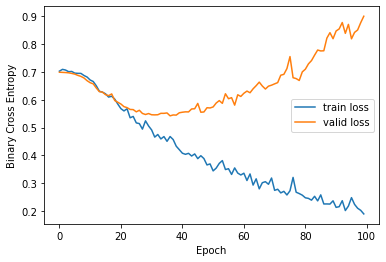

In [62]:
fig, ax = plt.subplots()
ax.plot(x, result['train_loss'])
ax.plot(x, result['valid_loss'])
ax.legend(['train loss', 'valid loss'], loc='center right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Binary Cross Entropy')
plt.savefig('train_result.png')
plt.show()

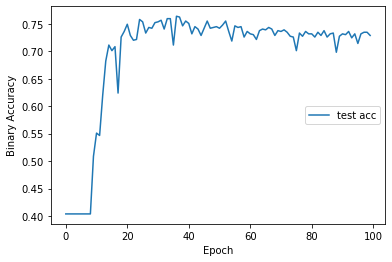

In [63]:
fig, ax = plt.subplots()
ax.plot(x, result['test_accuracy'])
ax.legend(['test acc'], loc='center right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Binary Accuracy')
plt.savefig('test_result.png')
plt.show()